# Introduction to OpenJij
OpenJij is a heuristic optimization library for the Ising model and QUBO.
The core of the optimization calculation is implemented in C++, but it has a Python interface that allows easy optimization coding with Python.

The first step is to install the OpenJij and the NumPy library if it is not installed yet. This can be achieved using the pip python package manager; for example:

In [1]:
!pip install numpy -U

In [2]:
!pip install openjij

In [1]:
# Check the installed version of OpenJij
!pip show openjij | grep "Version:"

Version: 0.9.2


## Optimization Computation with Ising Model using OpenJij

As described in [0-Introduction: Combinatorial optimization and the Ising model](./000-combinatorial_optimization_and_Ising_model.ipynb),
the Ising model is a model proposed to understand the behavior of magnetic materials and is written as follows:

$$H(\{\sigma_i\}) = \sum_{i > j} J_{ij}\sigma_i \sigma_j + \sum_{i=1}^N h_i \sigma_i$$
$$\sigma_i \in \{-1, 1\}, i=1,\cdots N$$

where $H(\{\sigma_i\})$ is called the Hamiltonian  which can be interpreted as an energy or a cost function.
$\sigma_i$ is a variable that takes either $1$ or $-1$.  

> $\sigma_i$ is sometimes called a spin variable or simply spin because it corresponds to a physical quantity called spin in physics.  
> Spin is described as a small magnet. $-1$ corresponds to a magnet facing up, and $1$ corresponds to a magnet facing down.


$H$ depends on the combination of variables $\{\sigma_i\} = \{\sigma_1, \sigma_2, \cdots, \sigma_N\}$.
$J_{ij}$ and $h_i$ represent the given problem, and they are called interaction coefficients and longitudinal magnetic fields, respectively.

OpenJij is a numerical library that performs simulated annealing or simulated quantum annealing given $J_{ij}$ and $h_i$ as inputs.
We use OpenJij to find the spin variable combination $\{\sigma_i\}$ that minimizes $H(\{\sigma_i\})$.


### How to Solve Problems with OpenJij
First, let's look at how OpenJij can be used in a simple example.
Let the number of variables be $N=5$ and the longitudinal fields and the interaction coefficients as:

$$h_i = -1~\text{for} ~\forall i, ~ J_{ij} = -1~\text{for} ~\forall i, j$$

Since all interactions are negative, we know that each spin variable should take the same value to have a lower energy state.
Also, since all longitudinal magnetic fields are negative, each spin variable should take the value of 1 to have lower energy.  
Thus, the optimal solution to this problem is $\{\sigma_i\} = \{1, 1, 1, 1, 1, 1\}$.

Now, let's see if we can obtain this result using OpenJij.

First, we prepare $h_i$ and $J_{ij}$ as input data.
Here, we create a dictionary with the respective indexes as keys and values as values.

In [3]:
import openjij as oj

# Define the vertical field and the interaction coefficient. 
# OpenJij accepts problems in a dictionary form.
N = 5
h = {i: -1 for i in range(N)}
J = {(i, j): -1 for i in range(N) for j in range(i+1, N)}

print('h_i: ', h)
print('Jij: ', J)

h_i:  {0: -1, 1: -1, 2: -1, 3: -1, 4: -1}
Jij:  {(0, 1): -1, (0, 2): -1, (0, 3): -1, (0, 4): -1, (1, 2): -1, (1, 3): -1, (1, 4): -1, (2, 3): -1, (2, 4): -1, (3, 4): -1}


Next, we perform the optimization calculation.
Here, we define an instance of `oj.SASampler` to perform the annealing method.
The annealing method is executed by passing $h_i$ and $J_{ij}$ as arguments of the `sample_ising` method.

Details of `oj.SASampler` and `sample_ising` and their return values are described at the end of this note.

In [4]:
# First define the instance of the sampler that solves the problem.
# The algorithm for solving the problem can be determined by which instance is selected.
sampler = oj.SASampler()
# Solve the problem by adding (h, J) to the sampler's method.
response = sampler.sample_ising(h, J, num_reads=1)

# The result of the calculation (state) is stored in `response.states`.
print(response.states)

# See the result with subscripts by using the samples function.
print([s for s in response.samples()])

[[1 1 1 1 1]]
[{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}]


Indeed, we obtained a state in which all spins were 1, as expected.

Above we passed $h_i$ and $J_{ij}$ as dictionaries, but NumPy-based input can be more convenient with huge problems.
OpenJij provides `oj.BinaryQuadraticModel.from_numpy_matrix` that converts the following form of a NumPy matrix to a form that OpenJij can solve.

$$ \begin{pmatrix}
h_{0} & J_{0,1} & \cdots & J_{0,N-1}\\
J_{1,0} & h_{1} & \cdots & J_{1,N-1}\\
\vdots & \vdots & \vdots & \vdots\\
J_{N-1,0} & J_{N-1,1} & \cdots & h_{N-1}\\
\end{pmatrix} $$

In [5]:
import numpy as np
mat = np.array([
    [-1,-0.5,-0.5,-0.5],
    [-0.5,-1,-0.5,-0.5],
    [-0.5,-0.5,-1,-0.5],
    [-0.5,-0.5,-0.5,-1]
    ])
print(mat)

# Use oj.BinaryQuadraticModel with the variable type (vartype) set to 'SPIN'.
bqm = oj.BinaryQuadraticModel.from_numpy_matrix(mat, vartype='SPIN')
# Each element for J_{ij} and J_{ji} are grouped together internally.
print(bqm)

sampler = oj.SASampler()
response = sampler.sample(bqm)

print(response.states)

[[-1.  -0.5 -0.5 -0.5]
 [-0.5 -1.  -0.5 -0.5]
 [-0.5 -0.5 -1.  -0.5]
 [-0.5 -0.5 -0.5 -1. ]]
BinaryQuadraticModel({3: -1.0, 2: -1.0, 1: -1.0, 0: -1.0}, {(1, 2): -1.0, (0, 2): -1.0, (1, 3): -1.0, (0, 3): -1.0, (2, 3): -1.0, (0, 1): -1.0}, 0.0, Vartype.SPIN, sparse=False)
[[1 1 1 1]]


When the data were given in a dictionary form, only the upper triangle portions of the interaction matrix were given, but when given in a NumPy matrix, the lower triangles are also included. Note that therefore the off-diagonal elements of the interaction matrix are given as -0.5, half of -1, to make the problem consistent with the case given in the dictionary.

## Optimization Computation with QUBO using OpenJij

When solving a real problem in society, it is often more straightforward to formulate the problem into a form called Quadratic Unconstrained Binary Optimization (QUBO) than to the Ising model.

QUBO is written as follows:

$$H(\{q_i\}) = \sum_{i\geq j} Q_{ij}q_i q_j$$
$$q_i \in \{0, 1\}$$

The difference from the Ising model is that the binary variables are either 0 or 1.
There are various possible ranges of how to take the sum of $\sum Q_{ij}$ (e.g. let Q be a symmetric matrix and summing over all ranges of i, j), but here we define it as above.

> The transformation formula $Q_i = (\sigma_i + 1)/2$ allows the Ising model and QUBO to be interconverted, and in that sense the two models are equivalent.

In QUBO, $Q_{ij}$ is given as an input, and the problem is to find the combination $\{q_i\}$ of 0 and 1 that minimizes $H(\{q_i\})$.
It is almost the same as the Ising model case mentioned earlier.

Also, since $q_i$ is a binary variable, we know that $q_i^2 = q_i$. Therefore, we can rewrite the above equation as follows:

$$H(\{q_i\}) = \sum_{i > j} Q_{ij}q_i q_j + \sum_i Q_{ii} q_i$$

Note that $Q_{ij}$ with the same subscripts corresponds to the coefficient of the first-order term of $q_i$.

Let us solve this in OpenJij.

In [6]:
# Define Q_ij in a dictionary type.
Q = {(0, 0): -1, (0, 1): -1, (1, 2): 1, (2, 2): 1}
sampler = oj.SASampler()
# Use .sample_qubo to solve QUBO problems.
response = sampler.sample_qubo(Q)
print(response.states)

[[1 1 0]]


Since the variables are 0, 1 in QUBO, we see that the solution is also output as 0, 1.  
Thus, the optimization problem can be solved using OpenJij for both the Ising model and QUBO.

## OpenJij Features

In this section, we explain the details of the above code.
OpenJij currently has two interfaces, and the one used above is the same interface as D-Wave Ocean. Therefore, being familiar with OpenJij, one can handle D-Wave Ocean easily.

> The other interface is not described here, but it has an ease of extension by directly using OpenJij's mechanism `graph, method, algorithm`. It should be sufficient here to use the interfaces covered in the cells above.

### Sampler

Above we defined an instance of a sampler after defining a dictionary-type problem as shown below:
```python
sampler = oj.SASampler()
```
Here we specify what algorithm this sampler instance uses.
To try other algorithms, change this sampler to use a different algorithm.
For example, the `SASampler` used in the example above is a sampler that samples the solution using an algorithm called simulated annealing.  
Another `SQASampler` is available to use simulated quantum annealing (SQA), an algorithm to simulate quantum annealing on a classical computer.

> The algorithm handled by OpenJij is a heuristic stochastic algorithm. The solution returned is different each time the problem is solved, and it is not always possible to obtain the optimal solution.
> Therefore, we solve the problem multiple times and look for the best solution among them. For this reason, we call it a "sampler" to express the idea of sampling the solution.


### sample_ising(h, J), sample_qubo(Q)
As mentioned above, when solving a problem, the longitudinal magnetic fields `h` and the interaction coefficients `J` are set as variables and substituted, as in `.sample_ising(h, J)`.

When performing optimization calculations for QUBO, we use `.sample_qubo(Q)`.

### Response

`.sample_ising(h, J)` returns the response class, which contains the solution obtained through the sampler and the energy of each solution.
The response class has various properties, and the main ones are:

- `.states`: list[list[int]]]
    - The number of num_reads count solutions is stored.
    > In physics, an array of spins (solutions) is called a state. We use .states to show that multiple (num_reads times) states are stored.
- `.energies`: list[float]
    - The energies of each solution for the num_reads times are stored.
- `.indices`: list[object]
    - The solution is stored in .states, and the corresponding indices of each spin are stored in .indices.
- `.first.sample`: dict
    - The minimum energy state is stored.
- `.first.energy`: float
    - The minimum energy value is stored.

> The response class inherits from the sample set class of D-Wave's dimod. More detailed information is described in the following link.  
> [dimod documentation, SampleSet](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampleset.html#dimod.SampleSet)

Let us take a look at an actual code.
Here, we try `num_reads=10` to get 10 solutions, and we use `SQASampler`, which is a sampler for simulated quantum annealing, instead of simulated annealing.

In [7]:
# The dictionary key which indicates the subscripts of h and J can also handle non-numeric values.
h = {'a': -1, 'b': -1}
J = {('a', 'b'): -1, ('b', 'c'): 1}
# By substituting 10 to the num_reads argument, we solve the calculation for 10 attempts with SQA in a single run.
sampler = oj.SQASampler()  
response = sampler.sample_ising(h, J, num_reads=10)
print(response.first.sample)
print(response.first.energy)

{'a': 1, 'b': 1, 'c': -1}
-4.0


In [8]:
# response.states contains 10 solutions.
print(response.states)

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]


In [9]:
# Check energies.
response.energies

array([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4.])

For all 10 times, the energy values are the same.  
Since the solution in `response.states` is a list, we do not know how it corresponds to the string `a, b, c`. To find out, `response.variables` is useful.

In [10]:
response.variables

Variables(['a', 'b', 'c'])

To know the state with the smallest energy value, `.first` works well.

In [11]:
response.first

Sample(sample={'a': 1, 'b': 1, 'c': -1}, energy=-4.0, num_occurrences=1)

## Optimization Calculations for Random QUBO Matrices

Since the problems solved above are too easy, let us try to solve a slightly more difficult problem to end this tutorial.

Here we solve a QUBO with 50 variables and randomly assigned $Q_{ij}$.

In [12]:
N = 50
# Randomly define Qij.
import random
Q = {(i, j): random.uniform(-1, 1) for i in range(N) for j in range(i+1, N)}

# Solve with OpenJij.
sampler = oj.SASampler()
response = sampler.sample_qubo(Q, num_reads=100)

In [13]:
# Check the first couple of energies.
response.energies[:5]

array([-67.29451672, -67.29451672, -67.29451672, -67.29451672,
       -66.48266432])

When looking at the energy, we see that it takes on a different value than in the previous example.
If we give $Q_{ij}$ randomly, the problem generally becomes more difficult. Therefore, the SA sampler gives different solutions every time.  
Let us visualize what kind of solution we get with a histogram of the energies.

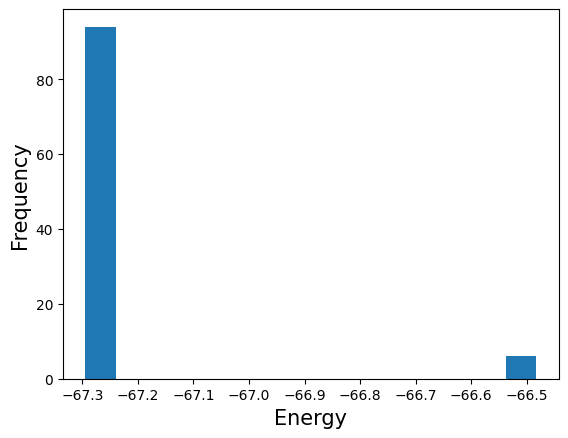

In [14]:
import matplotlib.pyplot as plt
plt.hist(response.energies, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

Lower energy represents a better state. The histogram above shows that in some cases, a high energy state is also calculated, but the majority of the results represent the lowest energy states.
The lowest energy state of the solved (sampled) states should be the closest to the optimal solution, and that solution can be found in `.states`.
> Note: SA does not necessarily lead to the optimal solution. Therefore, there is no guarantee that the solution with the lowest energy is the optimal solution. It is only an approximate solution.

In [15]:
import numpy as np

min_samples = response.first
min_samples

Sample(sample={0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1, 15: 0, 16: 1, 17: 1, 18: 1, 19: 0, 20: 0, 21: 1, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 1, 28: 0, 29: 1, 30: 0, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 0, 37: 1, 38: 1, 39: 1, 40: 0, 41: 0, 42: 1, 43: 1, 44: 1, 45: 0, 46: 1, 47: 1, 48: 1, 49: 0}, energy=-67.29451672334079, num_occurrences=1)

We now have the solution with the lowest energy. The state in `.first` is the approximate solution obtained this time. This means that we have "approximately solved the problem."

Here `num_occurrences` is the number of times the state was output as a result of the calculation.